In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

In [2]:
df = pd.read_csv('data.csv')
x_coords = df['XCOORD'].tolist()
y_coords = df['YCOORD'].tolist()
x_new = [x + 100 for x in x_coords]
x = x_coords + x_new
y = y_coords + y_coords
customer_data = np.column_stack((x, y))

In [35]:
# k-means
from sklearn.cluster import KMeans

num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(customer_data)
clusters = [[] for _ in range(num_clusters)]

E:\Anaconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


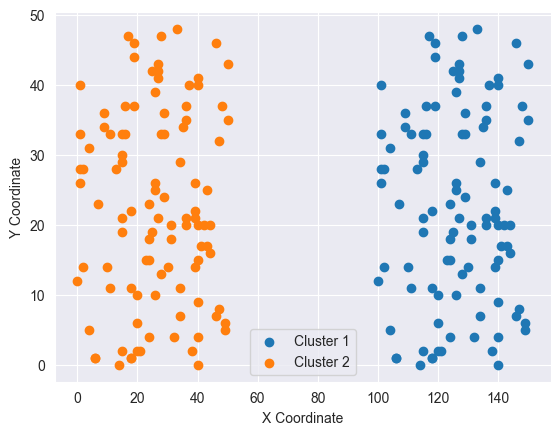

In [36]:
clusters_x = {}
clusters_y = {}
for cluster_idx in range(num_clusters):
    cluster_x = [x[i] for i, label in enumerate(cluster_labels) if label == cluster_idx]
    cluster_y = [y[i] for i, label in enumerate(cluster_labels) if label == cluster_idx]
    clusters_x[cluster_idx] = cluster_x
    clusters_y[cluster_idx] = cluster_y
    plt.scatter(cluster_x, cluster_y, label=f'Cluster {cluster_idx + 1}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.savefig('fig7.png')
plt.legend()
plt.show()

In [37]:
# adopt GA to each cluster
random.seed(42)
np.random.seed(42)
results_x = {}
results_y = {}
internal_cluster_distances = 0
for c in range(num_clusters):
    x_data = clusters_x[c]
    y_data = clusters_y[c]
    num_customers = len(x_data)
    distance_matrix = np.zeros((num_customers, num_customers))
    for i in range(num_customers):
        for j in range(num_customers):
            if i != j:
                distance_matrix[i][j] = np.sqrt((x_data[i] - x_data[j]) ** 2 + (y_data[i] - y_data[j]) ** 2)
    
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)
    toolbox = base.Toolbox()
    toolbox.register("indices", random.sample, range(num_customers), num_customers)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    def evaluate_tsp(individual):
        total_distance = 0
        for i in range(len(individual) - 1):
            total_distance += distance_matrix[individual[i]][individual[i + 1]]
        total_distance += distance_matrix[individual[-1]][individual[0]]  # Return to starting point
        return total_distance,
    
    toolbox.register("evaluate", evaluate_tsp)
    toolbox.register("mate", tools.cxOrdered)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)
    
    population = toolbox.population(n=800)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    
    best = tools.selBest(population, k=1)[0]
    best_distance = evaluate_tsp(best)[0]
    
    gen, max_gen = 0, 1000
    while gen < max_gen:
        gen += 1
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.7, mutpb=0.2)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
        population = toolbox.select(offspring + population, k=len(population))
        hof.update(population)
        best = tools.selBest(population, k=1)[0]
        best_distance = evaluate_tsp(best)[0]
        if gen % 200 == 0:
            print(f"cluster {c}, generation {gen}, best distance {best_distance}")
    optimized_path = list(best)
    optimized_x = [x_data[i] for i in optimized_path]
    optimized_y = [y_data[i] for i in optimized_path]
    
    optimized_x.append(optimized_x[0])
    optimized_y.append(optimized_y[0])
    
    results_x[c] = optimized_x
    results_y[c] = optimized_y
    internal_cluster_distances += best_distance

E:\Anaconda3\envs\torch\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
E:\Anaconda3\envs\torch\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


cluster 0, generation 200, best distance 659.2011446579643
cluster 0, generation 400, best distance 514.9463249333828
cluster 0, generation 600, best distance 512.288417586088
cluster 0, generation 800, best distance 507.88982896324467
cluster 0, generation 1000, best distance 502.30345286087095
cluster 1, generation 200, best distance 745.7428218832872
cluster 1, generation 400, best distance 624.4155442365873
cluster 1, generation 600, best distance 604.8002535304072
cluster 1, generation 800, best distance 595.2648643299656
cluster 1, generation 1000, best distance 577.7156031556302


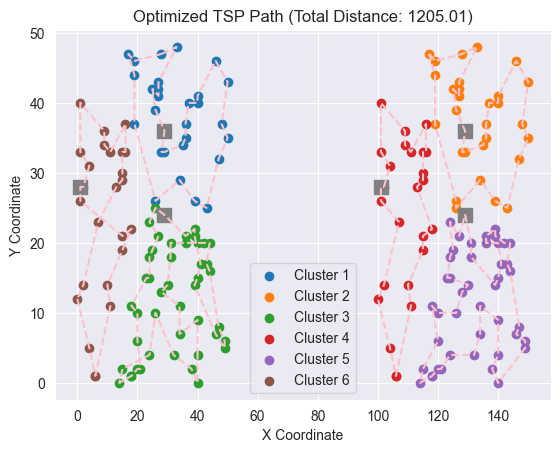

In [24]:
for cluster_idx in range(6):
    cluster_x = [x[i] for i, label in enumerate(cluster_labels) if label == cluster_idx]
    cluster_y = [y[i] for i, label in enumerate(cluster_labels) if label == cluster_idx]
    plt.scatter(cluster_x, cluster_y, label=f'Cluster {cluster_idx + 1}')
    plt.scatter(cluster_x[0], cluster_y[0], marker='s', color='gray', s=100)
    plt.plot(results_x[cluster_idx], results_y[cluster_idx], linestyle='dashed', color='pink')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Optimized TSP Path (Total Distance: 1205.01)')
plt.legend()
plt.savefig('fig8')
plt.show()

In [38]:
# define the visit order
cluster_distance_matrix = np.zeros((num_clusters, num_clusters))
for i in range(num_clusters):
        for j in range(num_clusters):
            if i != j:
                cluster_distance_matrix[i][j] = np.sqrt((results_x[i][0] - results_x[j][0]) ** 2 + (results_y[i][0] - results_y[j][0]) ** 2)
cluster_distance_matrix

array([[  0.        , 106.06601718],
       [106.06601718,   0.        ]])

6: 362.56123286396155, 842.4494052671431
4: 286.2448942361392, 896.186938686402
internal_cluster_distances
2: 106.07, 